In [5]:
import iris
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import datetime
import numpy as np
import iris.coords as icoords
import iris.coord_categorisation
import iris.quickplot as qplt 
import scipy 

In [6]:
#defining a function to calculate global average T
def area_average(cube):
    
    if cube.coord('latitude').bounds is None:
        cube.coord('latitude').guess_bounds()
        cube.coord('longitude').guess_bounds()
    
    grid_areas = iris.analysis.cartography.area_weights(cube)
    average = cube.collapsed(['latitude','longitude'],iris.analysis.MEAN, weights=grid_areas)
    
    return average

In [7]:
#defining a new function for time
def make_time(start):
    
    """time = "YYYY-MM" """
    
    time = pd.period_range(start=start , periods=120, freq="M") # 10 years
    time = [datetime.datetime(i.year, i.month, 16) for i in time]
    
    return time
    
time_1257 = make_time("1257-01") # make a time object to plot against

In [8]:
#defining function to merge cube list into single large cube
def merge_cubes(cubes): 
    
    """
    Merge all ensemble members into one cube
    All cubes given the same time coordinate
    """

    big_cube = iris.cube.CubeList()
    n=1
    for cube in cubes:
        ensemble_coord = icoords.AuxCoord(n, standard_name='realization')
        new_cube = cube.copy()
        new_cube.add_aux_coord(ensemble_coord)
        big_cube.append(new_cube)
        n+=1
    
    return big_cube.merge_cube()

In [9]:
#defining function to merge cube list into single large cube
def merge_cubes_again(cubes): 
    
    """
    Merge all ensemble members into one cube
    All cubes given the same time coordinate
    """

    big_cube = iris.cube.CubeList()
    for cube in cubes:
        new_cube = cube.copy()
        big_cube.append(new_cube)
    
    return big_cube.merge_cube()

In [10]:
#defining function to merge cube list into single large cube
def time_reset(cubes): 
    
    time_coord = cubes[0].coord('time')
    n=1
    for cube in cubes:
        cube.remove_coord('time')
        cube.add_dim_coord(time_coord,0)
        cube.remove_coord('forecast_reference_time')
        cube.remove_coord('forecast_period')
        n+=1
    
    return 

In [11]:
#setting file path and ensemble codes
dir_in_coupled = '/shared/netscratch/lrm49/Laura/'
coupled_cntl = ['u-bu651','u-bv666','u-bv668','u-bv669','u-bv670','u-bv674','u-bv676','u-bv677','u-bv678'] 
coupled_jul_east = ['u-bv020','u-bw758','u-bw761','u-bw762','u-bw764','u-bw765'] 
coupled_jul_west = ['u-bw763','u-bw766','u-bw767'] 
coupled_jan_east = ['u-ca322', 'u-ca323', 'u-ca324', 'u-ca325', 'u-ca328']
coupled_jan_west = ['u-ca326', 'u-ca327', 'u-ca330','u-ca331']

In [12]:
## Easterly ##
sat_east = iris.cube.CubeList()
for job_id in coupled_jul_east:

    dynamic_cube_july = iris.load(dir_in_coupled+'Samalas_July/'+job_id+'_precip.nc')
    precip_july = dynamic_cube_july.extract('precipitation_flux')[0]
    precip_mm_july = precip_july*86400
    precip_mm_july.units='mm/day'
    time_limit = precip_mm_july[6:120]

    sat_east.append(time_limit)
    
for job_id in coupled_jan_east:
    
    dynamic_cube_jan = iris.load(dir_in_coupled+'Samalas_Jan/'+job_id+'_precip.nc')
    precip_jan = dynamic_cube_jan.extract('precipitation_flux')[0]
    precip_mm_jan = precip_jan*86400
    precip_mm_jan.units='mm/day'
    time_limit = precip_mm_jan[0:114]
    
    sat_east.append(time_limit)

In [13]:
## Westerly ## 
sat_west = iris.cube.CubeList()
for job_id in coupled_jul_west:

    dynamic_cube_july = iris.load(dir_in_coupled+'Samalas_July/'+job_id+'_precip.nc')
    precip_july = dynamic_cube_july.extract('precipitation_flux')[0]
    precip_mm_july = precip_july*86400
    precip_mm_july.units='mm/day'
    time_limit = precip_mm_july[6:120]
    sat_west.append(time_limit)
    
for job_id in coupled_jan_west:
    
    dynamic_cube_jan = iris.load(dir_in_coupled+'Samalas_Jan/'+job_id+'_precip.nc')
    precip_jan = dynamic_cube_jan.extract('precipitation_flux')[0]
    precip_mm_jan = precip_jan*86400
    precip_mm_jan.units='mm/day'
    time_limit = precip_mm_jan[0:114]

    sat_west.append(time_limit)

In [14]:
## Control ## 
control = iris.cube.CubeList()
for job_id_2 in coupled_cntl:
    
    dynamic_cube_jan = iris.load(dir_in_coupled+'Control/'+job_id_2+'_precip.nc')
    precip_jan = dynamic_cube_jan.extract('precipitation_flux')[0]
    precip_mm_jan = precip_jan*86400
    precip_mm_jan.units='mm/day'
    time_limit = precip_mm_jan[0:114]

    control.append(time_limit)

In [15]:
#resetting time
time_reset(sat_east)
time_reset(sat_west)
time_reset(control)

In [16]:
#merging
sat_merged_east = merge_cubes(sat_east)
sat_merged_west = merge_cubes(sat_west)
one_big_control = merge_cubes(control)

In [17]:
mean_control = one_big_control.collapsed('realization',iris.analysis.MEAN)

#extracting relevant control ensembles to align with easterly ensembles
east_control_0 = one_big_control[0]
east_control_1 = one_big_control[1]
east_control_2 = one_big_control[2]
east_control_3 = one_big_control[3]
east_control_6 = one_big_control[6]

east_control = iris.cube.CubeList()
east_control.append(east_control_0)
east_control.append(east_control_1)
east_control.append(east_control_2)
east_control.append(east_control_3)
east_control.append(east_control_6)

east_control = merge_cubes_again(east_control)

east_control_y1 = east_control[:,0:12].collapsed('time',iris.analysis.MEAN)#averaging across first 12 months

#extracting relevant control ensembles to align with westerly ensembles

west_control_4 = one_big_control[4]
west_control_5 = one_big_control[5]
west_control_7 = one_big_control[7]
west_control_8 = one_big_control[8]


west_control = iris.cube.CubeList()
west_control.append(west_control_4)
west_control.append(west_control_5)
west_control.append(west_control_7)
west_control.append(west_control_8)

west_control = merge_cubes_again(west_control)

west_control_y1 = west_control[:,0:12].collapsed('time',iris.analysis.MEAN)#averaging across first 12 months



/home/lw602/.conda/envs/py27iris/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'realization'.
  warnings.warn(msg.format(self.name()))


In [18]:
mean_east_y1 = sat_merged_east[:,0:12].collapsed('time',iris.analysis.MEAN)
mean_west_y1 = sat_merged_west[:,0:12].collapsed('time',iris.analysis.MEAN)

In [19]:
## ANOVA TESTS##

#output p values for each grid point 

F, p = scipy.stats.f_oneway(east_control_y1.data,mean_east_y1.data)

p_el_nino = p

F, p = scipy.stats.f_oneway(west_control_y1.data,mean_west_y1.data)

p_west = p

In [20]:
#anomalies for individual ensembles
anomaly_east = sat_merged_east - mean_control.data
anomaly_west = sat_merged_west - mean_control.data


In [21]:
#mean anomalies
mean_east = anomaly_east.collapsed('realization',iris.analysis.MEAN)
mean_west = anomaly_west.collapsed('realization',iris.analysis.MEAN)

In [22]:
#mean anomalies averaged across first 12 months
east_y1 = mean_east[0:12].collapsed('time',iris.analysis.MEAN)
west_y1 = mean_west[0:12].collapsed('time',iris.analysis.MEAN)

In [23]:
## appending p-values to fake cubes which already have lat/long coords 

p_data_east = east_y1.copy()
p_data_east.data = p_el_nino

p_data_west = west_y1.copy()
p_data_west.data = p_west

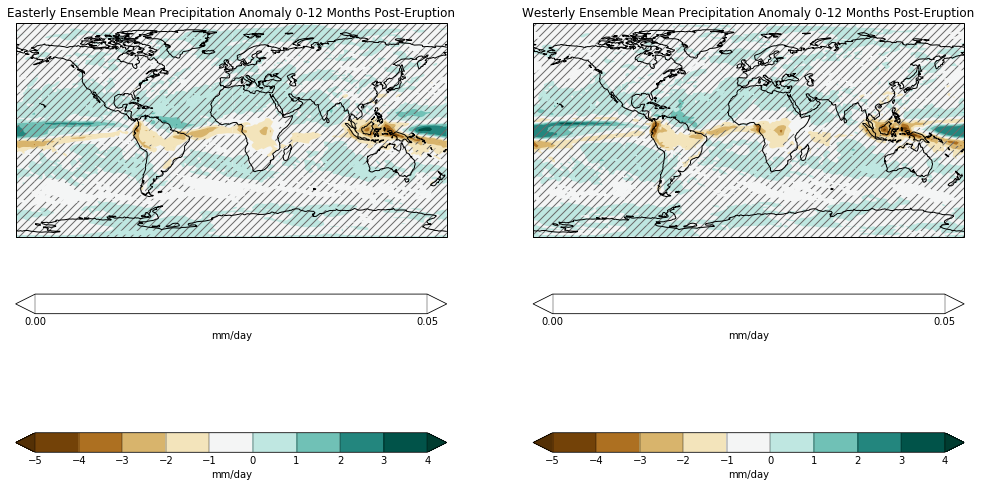

In [24]:
mpl.rcParams['hatch.color'] = 'dimgrey'
plt.figure(figsize=(17,10))
levels=np.arange(-5,5,1)

plt.subplot(1,2,1) 
qplt.contourf(east_y1, levels = levels, cmap='BrBG',  extend='both')
qplt.contourf(p_data_east, levels =[0,0.05], hatches =[ '///', None], alpha = 0, extend='both')#hash out anything less than 95% sig
plt.gca().coastlines() # add coastlines to the plot
plt.title('Easterly Ensemble Mean Precipitation Anomaly 0-12 Months Post-Eruption')

plt.subplot(1,2,2) 
qplt.contourf(west_y1, levels = levels, cmap='BrBG',  extend='both') 
qplt.contourf(p_data_west, levels =[0,0.05], hatches =[ '///', None], alpha = 0, extend='both')#hash out anything less than 95% sig
plt.gca().coastlines() # add coastlines to the plot
plt.title('Westerly Ensemble Mean Precipitation Anomaly 0-12 Months Post-Eruption')

plt.savefig('QBO Precip Y1.pdf')